In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 127.6 MB/s eta 0:00:00


# Bitstring

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import random

num_total = 19
dev = qml.device("default.qubit", wires=num_total, shots=None)

bit_to_word = {
    "000": "hola",
    "001": "mundo",
    "010": "amigo",
    "011": "casa",
    "100": "perro",
    "101": "gato",
    "110": "sol",
    "111": "luna"
}
word_list = list(bit_to_word.keys())

def bits_to_sentence(bitstring):
    w1 = bitstring[:3]
    w2 = bitstring[3:6]
    w3 = bitstring[6:]
    return f"{bit_to_word[w1]} {bit_to_word[w2]} {bit_to_word[w3]}"

def random_sentence():
    return "".join(random.choice(word_list) for _ in range(3))

def neighbor(sentence):
    words = [sentence[i*3:(i+1)*3] for i in range(3)]
    idx = random.randrange(3)
    current_word = words[idx]
    new_word = random.choice([w for w in word_list if w != current_word])
    words[idx] = new_word
    return "".join(words)

desired_bitstring = "000100010"  # "hola perro amigo"
desired_bits = [int(b) for b in desired_bitstring]


theta_A = 0.2  # ángulo para el registro candidato
theta_B = 0.1  # ángulo para el registro de referencia

@qml.qnode(dev)
def classifier_swap(candidate):
    # Preparar registro candidato
    candidate_bits = [int(b) for b in candidate]
    qml.BasisState(candidate_bits, wires=range(1, 10))
    for i in range(1, 10):
        qml.RY(theta_A, wires=i)

    # Preparar registro de referencia
    qml.BasisState(desired_bits, wires=range(10, 19))
    for i in range(10, 19):
        qml.RY(theta_B, wires=i)

    # SWAP test con qubit ancilla
    qml.Hadamard(wires=0)
    for i in range(9):
        qml.CSWAP(wires=[0, i+1, i+10])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sentence(candidate):
    probs = classifier_swap(candidate)
    fidelity = 2 * probs[0] - 1  # valor entre 0 y 1
    # Si la fidelidad es negativa (lo cual no debería ocurrir), se trata como 0.
    return fidelity**(1/9) if fidelity > 0 else 0

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    current = random_sentence()
    current_score = score_sentence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor(current)
        candidate_score = score_sentence(candidate)
        delta = candidate_score - current_score
        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, candidate_score
        if current_score > best_score:
            best, best_score = current, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria encontrada en la iteración {t}.")
            break
    return best, best_score, t


if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    print("Búsqueda de una oración con score (fidelidad) >= 0.95 (medido a nivel qubit)")
    best_candidate, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)
    print("\nOración encontrada:", bits_to_sentence(best_candidate))
    print("Bitstring:", best_candidate)
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")


Búsqueda de una oración con score (fidelidad) >= 0.95 (medido a nivel qubit)
Solución satisfactoria encontrada en la iteración 54.

Oración encontrada: hola perro amigo
Bitstring: 000100010
Score obtenido: 0.9975 (en 54 iteraciones)


(<Figure size 1500x2000 with 1 Axes>, <Axes: >)

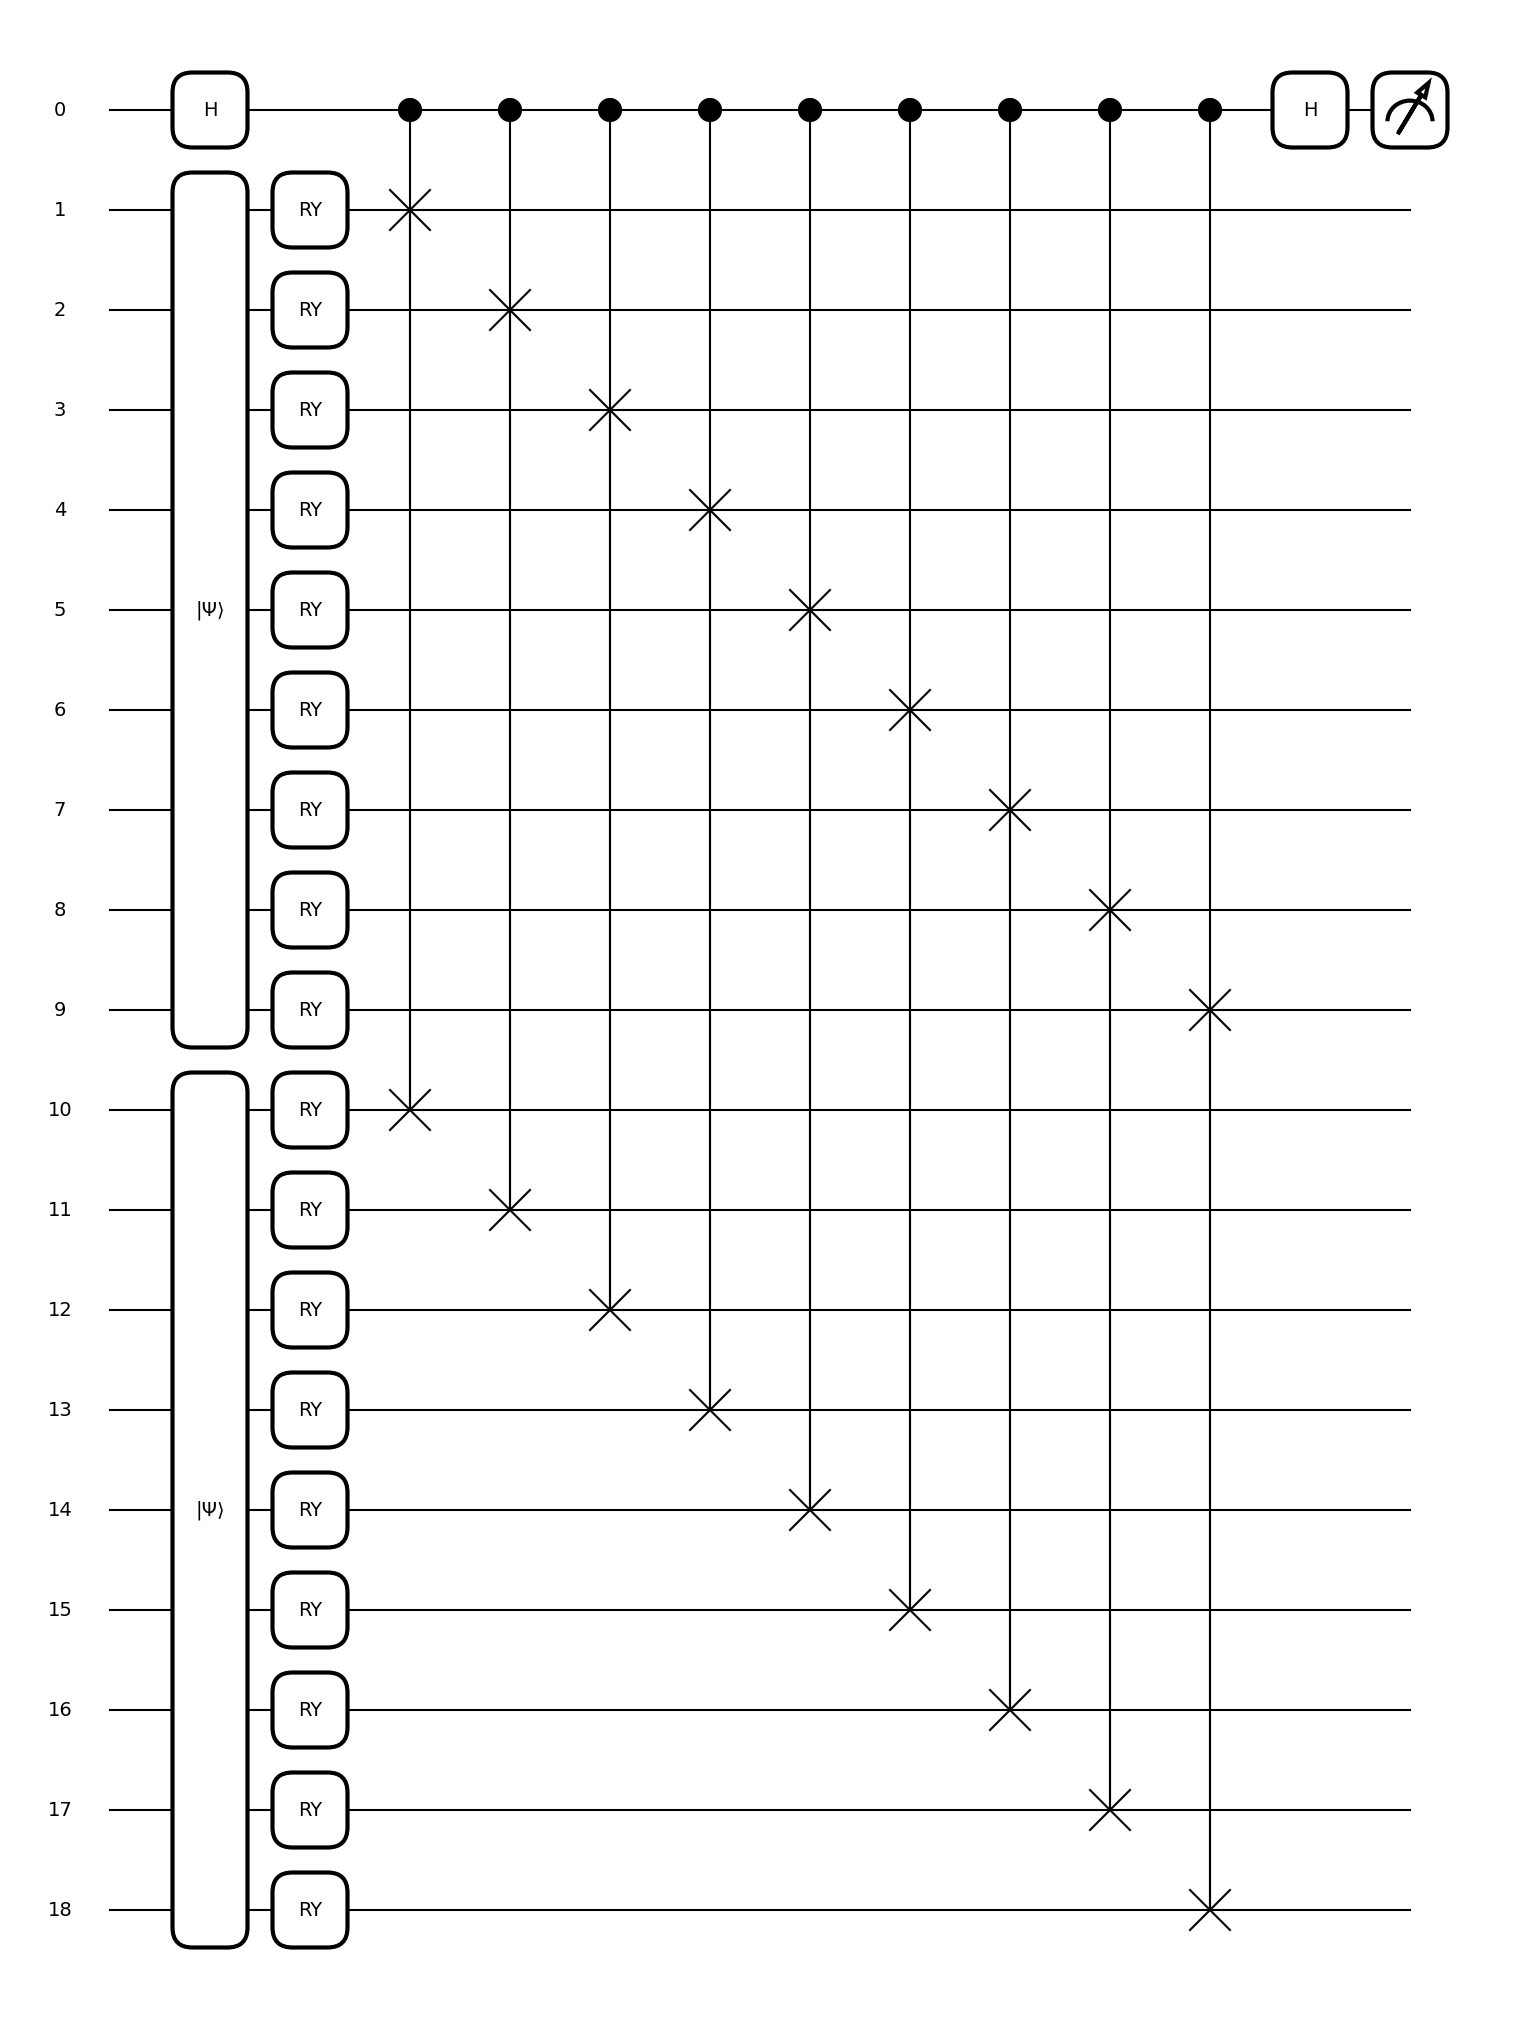

In [ ]:
qml.draw_mpl(classifier_swap)("000100010")

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import random
import math

num_qubits = 7  # 3 + 3 + 1 ancilla

dev = qml.device("default.qubit", wires=num_qubits, shots=None)

bit_to_word = {
    "000": "hola",
    "001": "mundo",
    "010": "amigo",
    "011": "casa",
    "100": "perro",
    "101": "gato",
    "110": "sol",
    "111": "luna"
}

word_list = list(bit_to_word.keys())

def random_sentence_3words():
    return "".join(random.choice(word_list) for _ in range(3))

def decode_3words(bitstring_9):
    w1 = bitstring_9[0:3]
    w2 = bitstring_9[3:6]
    w3 = bitstring_9[6:9]
    return f"{bit_to_word[w1]} {bit_to_word[w2]} {bit_to_word[w3]}"

def neighbor_3words(sentence_9):
    words_bits = [sentence_9[i*3:(i+1)*3] for i in range(3)]
    idx = random.randrange(3)
    old_word = words_bits[idx]
    new_word = random.choice([w for w in word_list if w != old_word])
    words_bits[idx] = new_word
    return "".join(words_bits)

@qml.qnode(dev)
def swap_test_3bits(candidate_bits, reference_bits):

    qml.BasisState(candidate_bits, wires=[1,2,3])
    qml.BasisState(reference_bits, wires=[4,5,6])

    qml.Hadamard(wires=0)
    for i in range(3):
        qml.CSWAP(wires=[0, 1+i, 4+i])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def fidelity_3bits(cand_bits, ref_bits):
    probs = swap_test_3bits(cand_bits, ref_bits)
    f = 2*probs[0] - 1
    return f if f>0 else 0

def compare_sentences_3words(sent_cand_9, sent_ref_9):
    """
    Divide en 3 words de 3 bits, hace SWAP test 3 veces y combina
    """
    c1, c2, c3 = sent_cand_9[:3], sent_cand_9[3:6], sent_cand_9[6:9]
    r1, r2, r3 = sent_ref_9[:3], sent_ref_9[3:6], sent_ref_9[6:9]

    cand1 = [int(b) for b in c1]
    cand2 = [int(b) for b in c2]
    cand3 = [int(b) for b in c3]
    ref1  = [int(b) for b in r1]
    ref2  = [int(b) for b in r2]
    ref3  = [int(b) for b in r3]

    f1 = fidelity_3bits(cand1, ref1)
    f2 = fidelity_3bits(cand2, ref2)
    f3 = fidelity_3bits(cand3, ref3)

    combined = (f1 * f2 * f3)**(1/3)
    return combined

def simulated_annealing(
        desired_9,
        max_iters=500,
        T0=1.0,
        threshold=0.95):
    current = random_sentence_3words()
    current_score = compare_sentences_3words(current, desired_9)
    best, best_score = current, current_score

    for t in range(1, max_iters+1):
        T = T0/(t**0.5)
        candidate = neighbor_3words(current)
        cand_score = compare_sentences_3words(candidate, desired_9)
        delta = cand_score - current_score
        if (delta > 0) or (np.exp(delta / T) > random.random()):
            current, current_score = candidate, cand_score
        if current_score > best_score:
            best, best_score = candidate, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria en iteración {t}.")
            break

    return best, best_score, t

if __name__=="__main__":
    random.seed(42)
    np.random.seed(42)

    desired_9 = "000100010"  # '000'->hola, '100'->perro, '010'->amigo
    print("Referencia:", decode_3words(desired_9))

    best_candidate, best_score, iters = simulated_annealing(desired_9, max_iters=1000, T0=1.0, threshold=0.95)

    print("\nOración encontrada:", decode_3words(best_candidate))
    print("Bitstring:", best_candidate)
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")


Referencia: hola perro amigo
Solución satisfactoria en iteración 112.

Oración encontrada: hola perro amigo
Bitstring: 000100010
Score obtenido: 1.0000 (en 112 iteraciones)


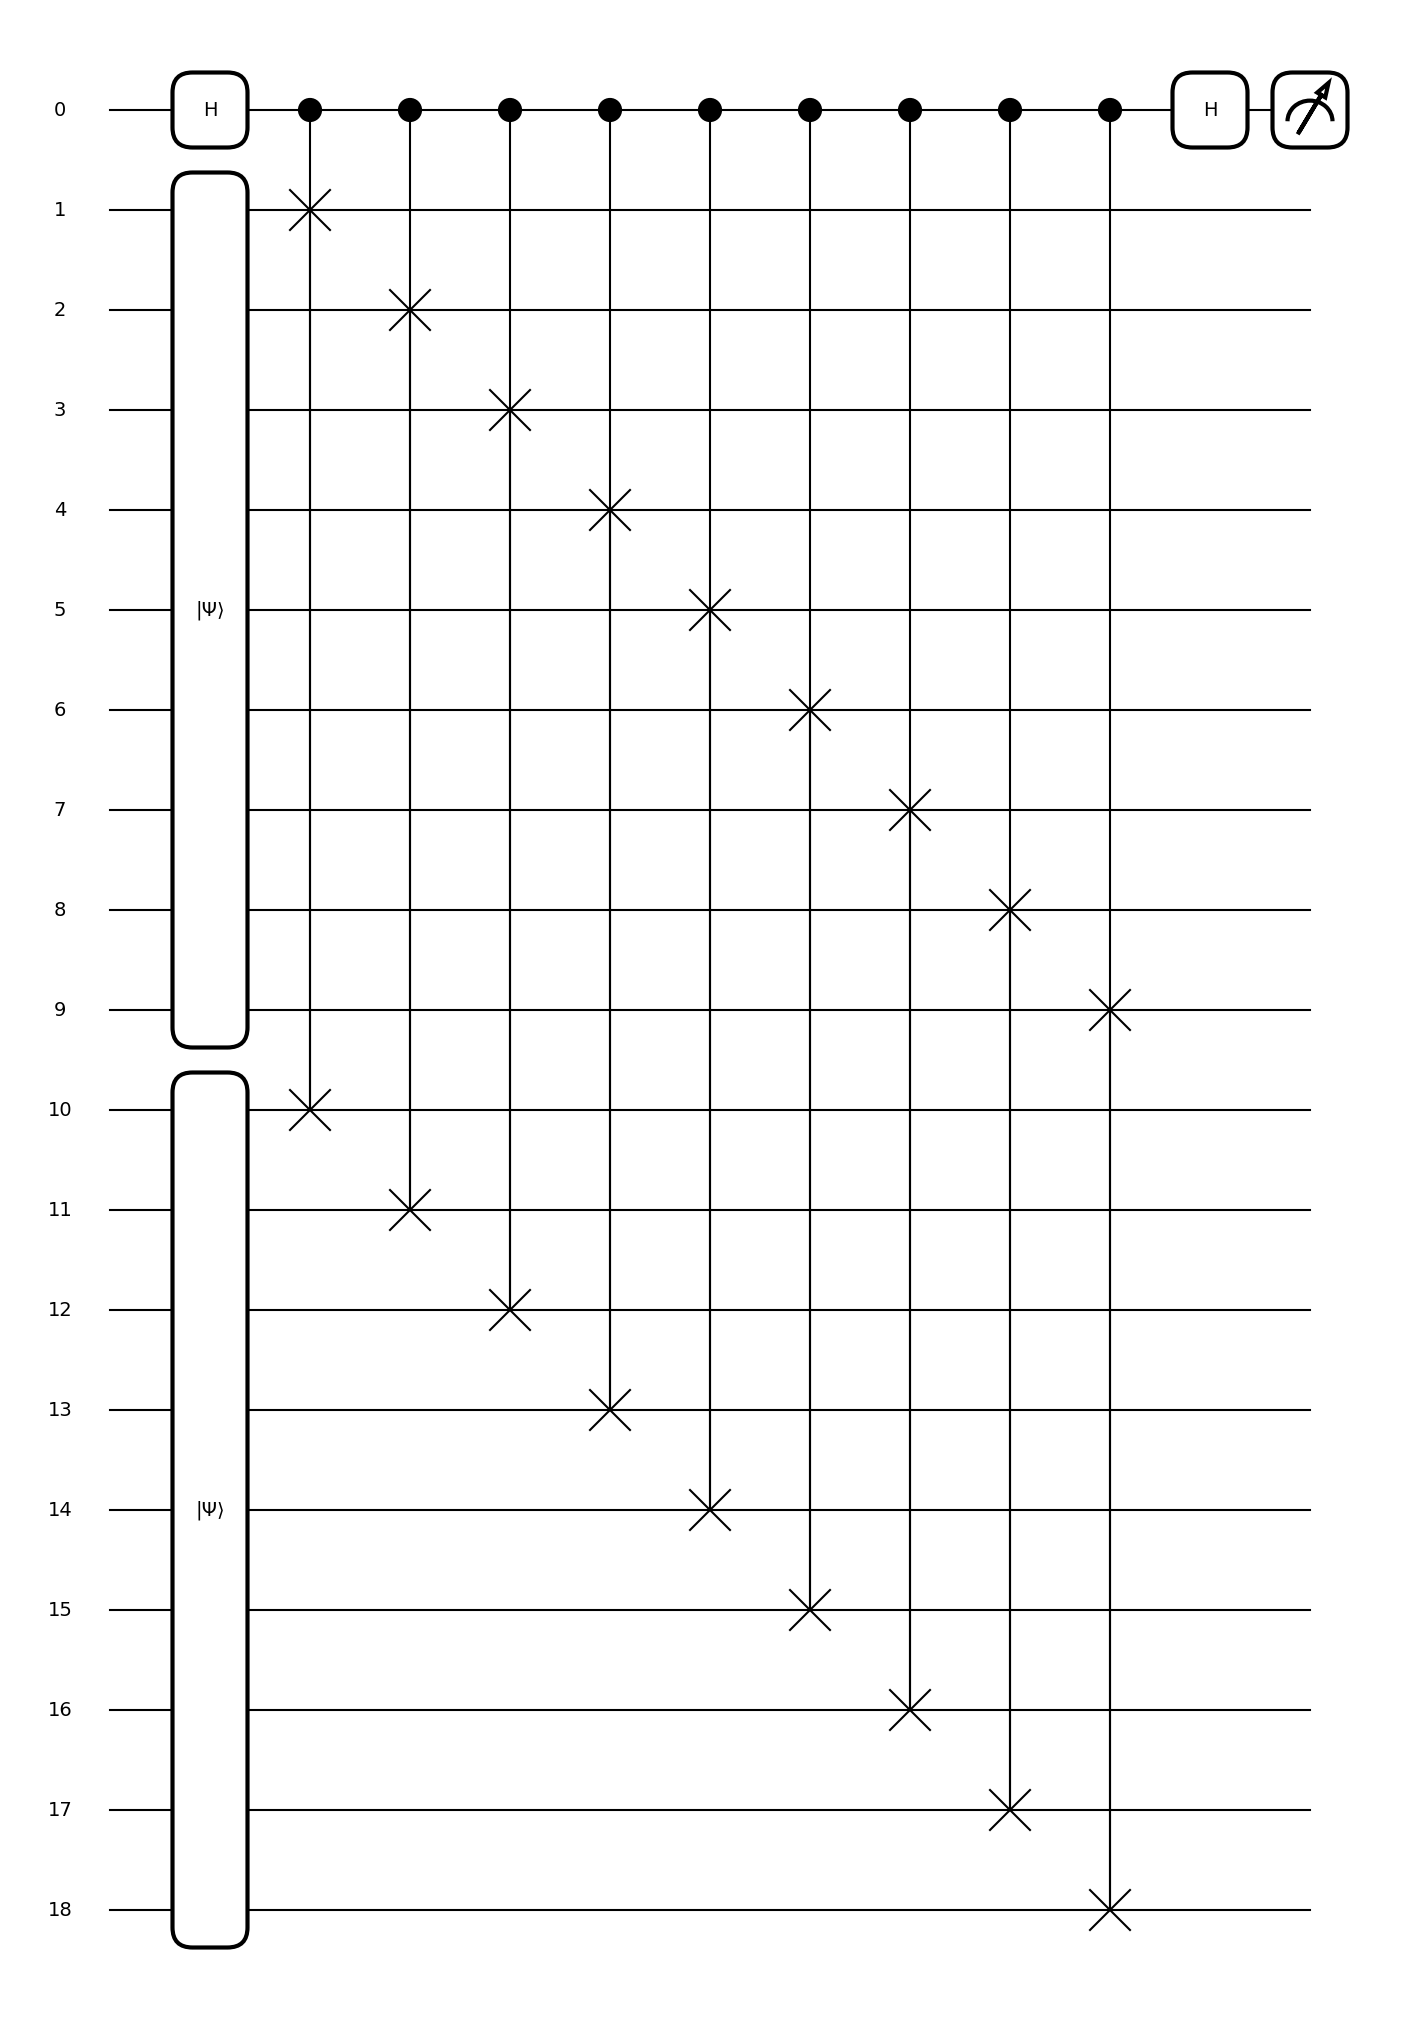

 0: ──H───╭●────╭●────╭●────╭●────╭●────╭●────╭●────╭●────╭●─────H─┤  Probs
 1: ─╭|Ψ⟩─├SWAP─│─────│─────│─────│─────│─────│─────│─────│────────┤       
 2: ─├|Ψ⟩─│─────├SWAP─│─────│─────│─────│─────│─────│─────│────────┤       
 3: ─├|Ψ⟩─│─────│─────├SWAP─│─────│─────│─────│─────│─────│────────┤       
 4: ─├|Ψ⟩─│─────│─────│─────├SWAP─│─────│─────│─────│─────│────────┤       
 5: ─├|Ψ⟩─│─────│─────│─────│─────├SWAP─│─────│─────│─────│────────┤       
 6: ─├|Ψ⟩─│─────│─────│─────│─────│─────├SWAP─│─────│─────│────────┤       
 7: ─├|Ψ⟩─│─────│─────│─────│─────│─────│─────├SWAP─│─────│────────┤       
 8: ─├|Ψ⟩─│─────│─────│─────│─────│─────│─────│─────├SWAP─│────────┤       
 9: ─╰|Ψ⟩─│─────│─────│─────│─────│─────│─────│─────│─────├SWAP────┤       
10: ─╭|Ψ⟩─╰SWAP─│─────│─────│─────│─────│─────│─────│─────│────────┤       
11: ─├|Ψ⟩───────╰SWAP─│─────│─────│─────│─────│─────│─────│────────┤       
12: ─├|Ψ⟩─────────────╰SWAP─│─────│─────│─────│─────│─────│────────┤       
13: ─├|Ψ⟩───

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

num_wires = 19
dev = qml.device("default.qubit", wires=num_wires, shots=None)

@qml.qnode(dev)
def big_swap_test(candidate_9bits, reference_9bits):

    # Convertir strings '000100010' en listas [0,0,0,1,0,0,0,1,0]
    cand_bits = [int(b) for b in candidate_9bits]
    ref_bits  = [int(b) for b in reference_9bits]

    # Preparar estado base
    qml.BasisState(cand_bits, wires=range(1, 10))
    qml.BasisState(ref_bits, wires=range(10, 19))

    # SWAP test
    qml.Hadamard(wires=0)
    for i in range(9):
        qml.CSWAP(wires=[0, 1 + i, 10 + i])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

if __name__ == '__main__':

    # Ejemplo: 'hola perro amigo' => "000100010"
    candidate = "000100010"
    # Ejemplo: 'hola sol luna' => "000110111"
    reference = "000110111"

    fig, ax = qml.draw_mpl(big_swap_test)(candidate, reference)
    plt.show()

    ascii_circuit = qml.draw(big_swap_test)(candidate, reference)
    print(ascii_circuit)


# Fase

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import random


num_total = 7
dev = qml.device("default.qubit", wires=num_total, shots=None)


vocabulary = {
    "hola": 0.0,
    "mundo": np.pi / 4,
    "amigo": np.pi / 2,
    "casa": 3 * np.pi / 4,
    "perro": np.pi,
    "gato": 5 * np.pi / 4,
    "sol": 3 * np.pi / 2,
    "luna": 7 * np.pi / 4
}

def encode_word(word, wire):
    qml.Hadamard(wires=wire)
    qml.RZ(vocabulary[word], wires=wire)

def prepare_sequence(sequence, wires):
    for word, wire in zip(sequence, wires):
        encode_word(word, wire)

def random_sequence():
    return [random.choice(list(vocabulary.keys())) for _ in range(3)]

def neighbor_sequence(seq):
    new_seq = seq.copy()
    idx = random.randrange(len(new_seq))
    alternatives = [w for w in vocabulary if w != new_seq[idx]]
    new_seq[idx] = random.choice(alternatives)
    return new_seq

def sequence_to_string(seq):
    return " ".join(seq)

reference_seq = ["hola", "perro", "amigo"]

theta_A = 0.2
theta_B = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):

    # Registro candidato
    prepare_sequence(candidate_seq, wires=range(1,4))
    for i in range(1,4):
        qml.RY(theta_A, wires=i)

    # Registro de referencia
    prepare_sequence(reference_seq, wires=range(4,7))
    for i in range(4,7):
        qml.RY(theta_B, wires=i)

    # SWAP test
    qml.Hadamard(wires=0)
    for i in range(3):
        qml.CSWAP(wires=[0, i+1, i+4])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):
    probs = classifier_swap(seq)
    fidelity = 2 * probs[0] - 1
    return fidelity**(1/3) if fidelity > 0 else 0

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    current = random_sequence()
    current_score = score_sequence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor_sequence(current)
        candidate_score = score_sequence(candidate)
        delta = candidate_score - current_score
        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, candidate_score
        if current_score > best_score:
            best, best_score = candidate, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria encontrada en la iteración {t}.")
            break

    return best, best_score, t

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    print("Búsqueda de una secuencia con score >= 0.95 usando 1 qubit por palabra (dim=2).")
    best_candidate, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)
    print("\nSecuencia encontrada:", sequence_to_string(best_candidate))
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")


Búsqueda de una secuencia con score >= 0.95 usando 1 qubit por palabra (dim=2).
Solución satisfactoria encontrada en la iteración 63.

Secuencia encontrada: hola perro amigo
Score obtenido: 0.9983 (en 63 iteraciones)


(<Figure size 1000x800 with 1 Axes>, <Axes: >)

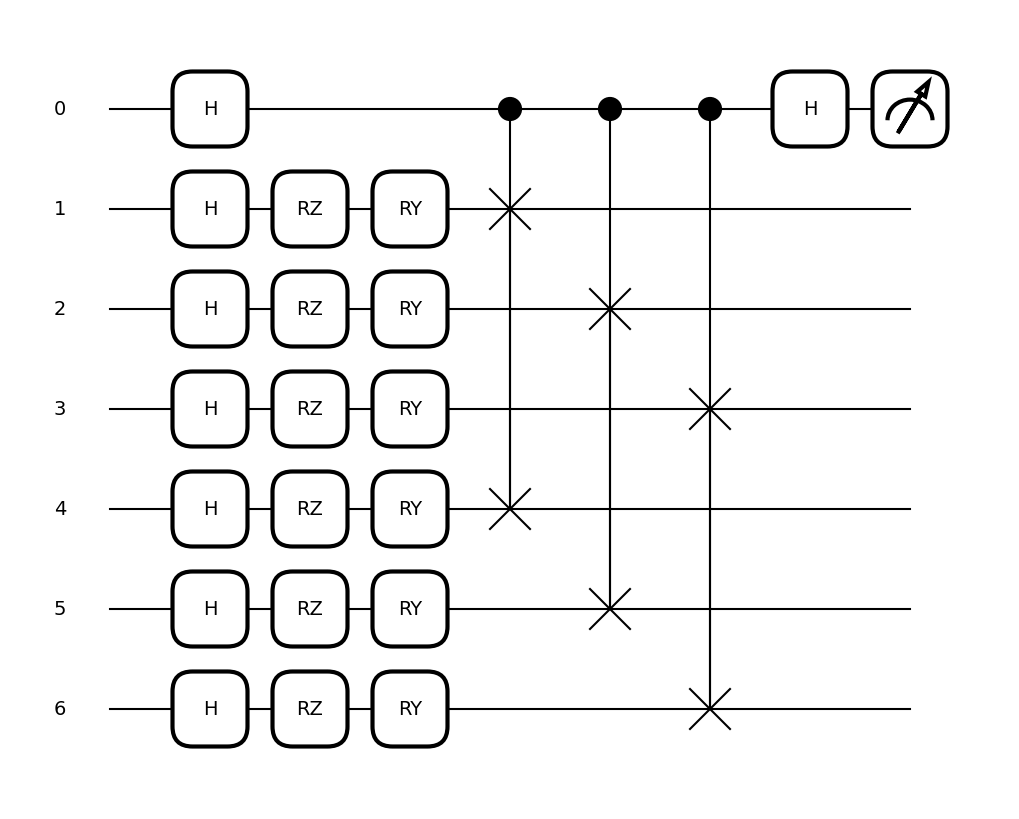

In [ ]:
qml.draw_mpl(classifier_swap)(["hola", "perro", "amigo"])

Si un qubit tiene infinitos estados, ¿Podría codificar todas las palabras en un único qubit?

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import random
import math

num_total = 11
dev = qml.device("default.qubit", wires=num_total, shots=None)

words = ["hola", "mundo", "amigo", "casa", "perro",
         "gato", "sol", "luna", "árbol", "cielo",
         "agua", "fuego", "tierra", "aire", "estrella"]

vocabulary = { word: (2 * np.pi * i / len(words)) for i, word in enumerate(words) }

def encode_word(word, wire):
    qml.Hadamard(wires=wire)
    qml.RZ(vocabulary[word], wires=wire)

def prepare_sequence(sequence, wires):
    for word, wire in zip(sequence, wires):
        encode_word(word, wire)

def random_sequence():
    return [random.choice(words) for _ in range(5)]

def neighbor_sequence(seq):
    new_seq = seq.copy()
    idx = random.randrange(len(new_seq))
    alternatives = [w for w in words if w != new_seq[idx]]
    new_seq[idx] = random.choice(alternatives)
    return new_seq

def sequence_to_string(seq):
    return " ".join(seq)

reference_seq = ["hola", "perro", "amigo", "casa", "sol"]

theta_A = 0.2
theta_B = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):

    # Registro candidato
    prepare_sequence(candidate_seq, wires=range(1,6))
    for i in range(1,6):
        qml.RY(theta_A, wires=i)

    # Registro de referencia
    prepare_sequence(reference_seq, wires=range(6,11))
    for i in range(6,11):
        qml.RY(theta_B, wires=i)

    # SWAP test
    qml.Hadamard(wires=0)
    for i in range(5):
        qml.CSWAP(wires=[0, i+1, i+6])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):
    probs = classifier_swap(seq)
    fidelity = 2 * probs[0] - 1
    return fidelity**(1/5) if fidelity > 0 else 0

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    current = random_sequence()
    current_score = score_sequence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor_sequence(current)
        candidate_score = score_sequence(candidate)
        delta = candidate_score - current_score
        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, candidate_score
        if current_score > best_score:
            best, best_score = candidate, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria encontrada en la iteración {t}.")
            break

    return best, best_score, t

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    print("Búsqueda de una secuencia con score >= 0.95 usando 1 qubit por palabra (dim=2).")
    best_candidate, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)
    print("\nSecuencia encontrada:", sequence_to_string(best_candidate))
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")


Búsqueda de una secuencia con score >= 0.95 usando 1 qubit por palabra (dim=2).
Solución satisfactoria encontrada en la iteración 77.

Secuencia encontrada: estrella casa mundo amigo sol
Score obtenido: 0.9641 (en 77 iteraciones)


(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

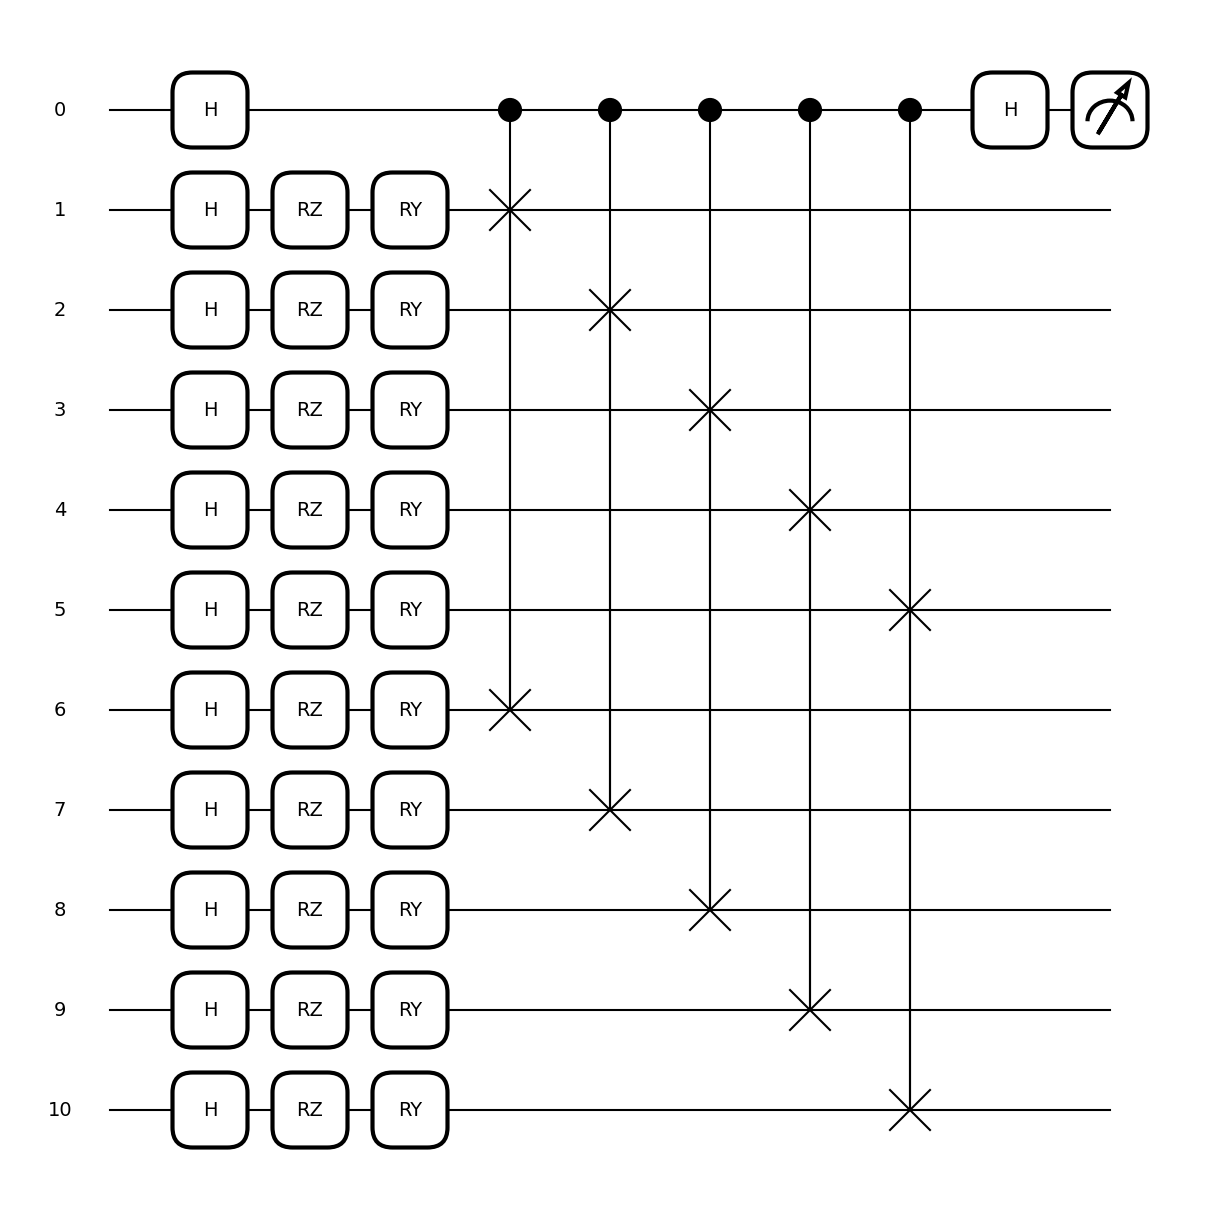

In [ ]:
qml.draw_mpl(classifier_swap)(["hola", "perro", "amigo", "casa", "sol"])

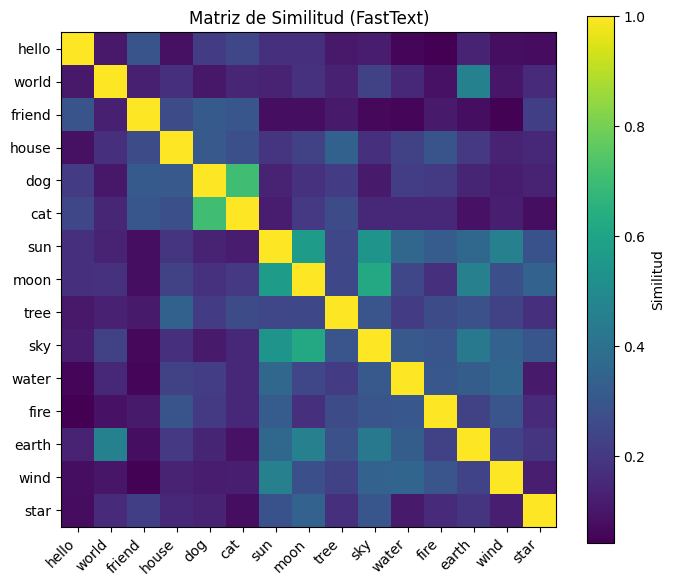

Búsqueda de una secuencia con score >= 0.95 usando codificación amplitud+fase.
Solución satisfactoria encontrada en la iteración 45.

Secuencia encontrada: star fire friend water sun
Score obtenido: 0.9659 (en 45 iteraciones)


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import random
import math

import fasttext
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


fasttext_model = fasttext.load_model("cc.en.300.bin")

def get_similarity(word1, word2):
    """Calcula la similitud coseno entre dos palabras usando FastText."""
    vec1 = fasttext_model.get_word_vector(word1)
    vec2 = fasttext_model.get_word_vector(word2)
    sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return sim

words = [
    "hello", "world", "friend", "house", "dog",
    "cat", "sun", "moon", "tree", "sky",
    "water", "fire", "earth", "wind", "star"
]

n = len(words)

similarity_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity_matrix[i, j] = get_similarity(words[i], words[j])

plt.figure(figsize=(7,6))
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Similitud")
plt.xticks(range(n), words, rotation=45, ha='right')
plt.yticks(range(n), words)
plt.title("Matriz de Similitud (FastText)")
plt.tight_layout()
plt.show()

# Distancia = 1 - similitud
distance_matrix = 1.0 - similarity_matrix

mds_2d = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords_2d = mds_2d.fit_transform(distance_matrix)

r_vals = np.sqrt(coords_2d[:,0]**2 + coords_2d[:,1]**2)
r_max = np.max(r_vals) if np.max(r_vals) != 0 else 1e-9

vocabulary = {}

for i, w in enumerate(words):
    x, y = coords_2d[i]
    r = np.sqrt(x*x + y*y)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2*np.pi

    normalized_r = r / r_max
    theta = np.pi * normalized_r

    vocabulary[w] = (theta, phi)


num_total = 11
dev = qml.device("default.qubit", wires=num_total, shots=None)

def encode_word(word, wire):

    theta, phi = vocabulary[word]
    qml.RY(theta, wires=wire)
    qml.RZ(phi, wires=wire)

def prepare_sequence(sequence, wires):
    for word, wire in zip(sequence, wires):
        encode_word(word, wire)

def random_sequence():
    return [random.choice(words) for _ in range(5)]

def neighbor_sequence(seq):
    new_seq = seq.copy()
    idx = random.randrange(len(seq))
    alternatives = [w for w in words if w != new_seq[idx]]
    new_seq[idx] = random.choice(alternatives)
    return new_seq

def sequence_to_string(seq):
    return " ".join(seq)

reference_seq = ["hello", "dog", "friend", "house", "sun"]


theta_A = 0.2
theta_B = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):

    # Registro candidato
    prepare_sequence(candidate_seq, wires=range(1,6))
    for i in range(1,6):
        qml.RY(theta_A, wires=i)

    # Registro de referencia
    prepare_sequence(reference_seq, wires=range(6,11))
    for i in range(6,11):
        qml.RY(theta_B, wires=i)

    # SWAP test
    qml.Hadamard(wires=0)
    for i in range(5):
        qml.CSWAP(wires=[0, i+1, i+6])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):
    probs = classifier_swap(seq)
    fidelity = 2 * probs[0] - 1
    return fidelity**(1/5) if fidelity > 0 else 0

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    current = random_sequence()
    current_score = score_sequence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor_sequence(current)
        candidate_score = score_sequence(candidate)
        delta = candidate_score - current_score
        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, candidate_score
        if current_score > best_score:
            best, best_score = current, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria encontrada en la iteración {t}.")
            break

    return best, best_score, t

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    print("Búsqueda de una secuencia con score >= 0.95 usando codificación amplitud+fase.")
    best_candidate, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)
    print("\nSecuencia encontrada:", sequence_to_string(best_candidate))
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")


(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

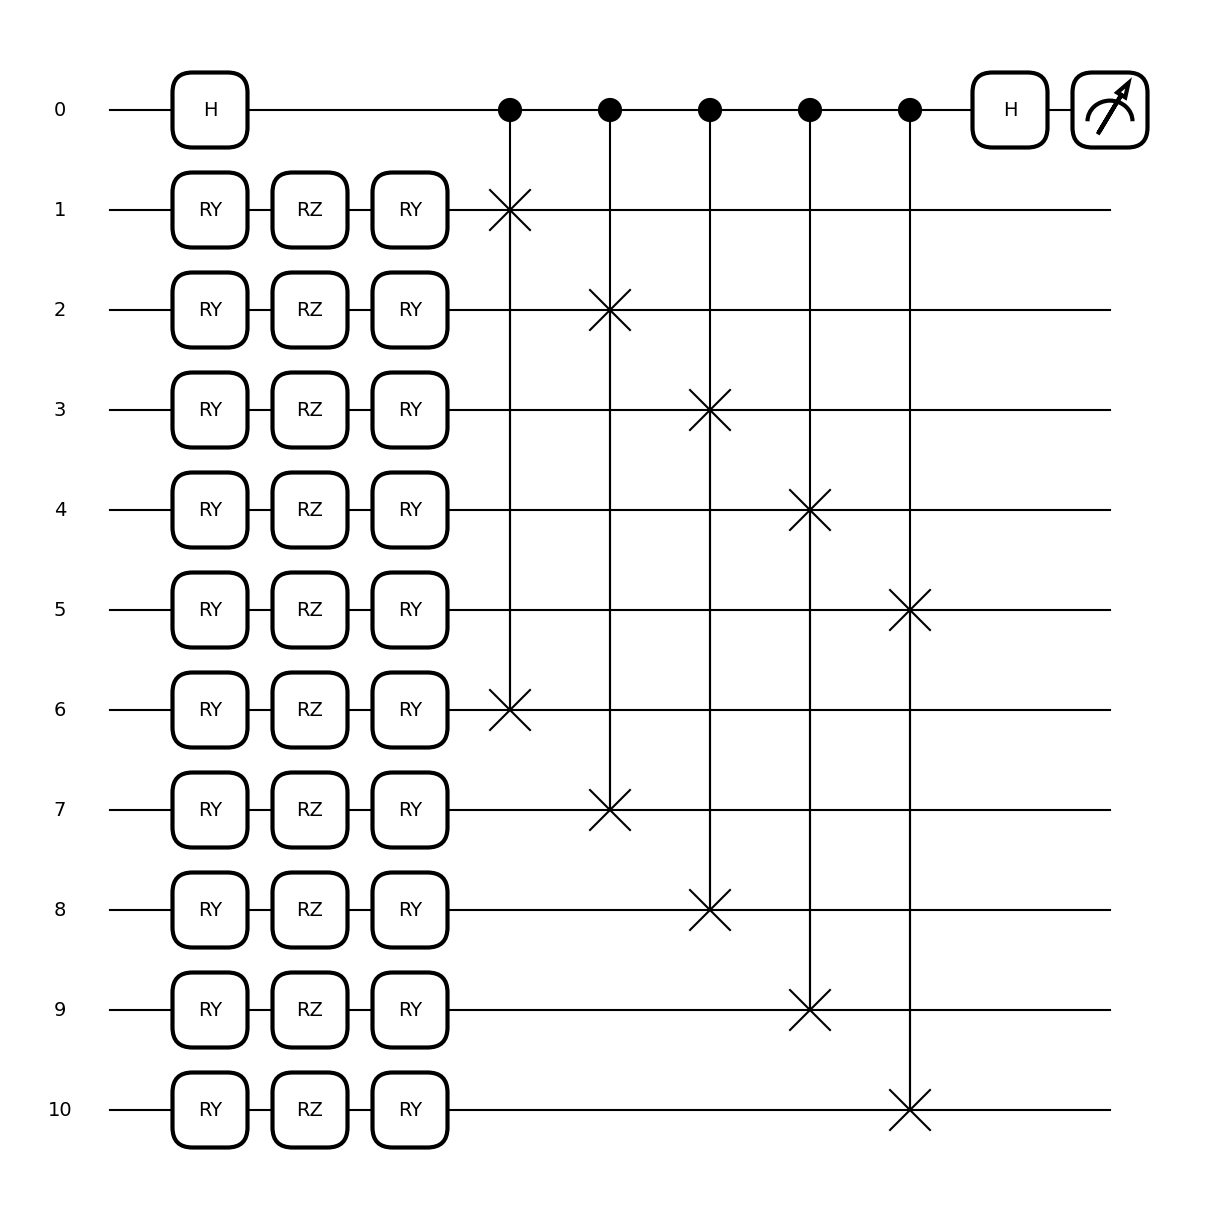

In [ ]:
qml.draw_mpl(classifier_swap)(["hello", "dog", "friend", "house", "sun"])

# Amplitud

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import random

num_total = 7
dev = qml.device("default.qubit", wires=num_total, shots=None)

vocabulary = {
    "hola": np.array([0.8, 0.6]),
    "mundo": np.array([0.7, 0.1]),
    "amigo": np.array([0.6, 0.6]),
    "casa": np.array([0.1, 0.9]),
    "perro": np.array([0.3, 0.3]),
    "gato": np.array([0.4, 0.2]),
    "sol": np.array([0.8, 0.1]),
    "luna": np.array([0.2, 0.8])
}

for w in vocabulary:
    vec = vocabulary[w]
    vocabulary[w] = vec / np.linalg.norm(vec)

def sequence_to_vector(sequence):

    state = vocabulary[sequence[0]]
    for word in sequence[1:]:
        state = np.kron(state, vocabulary[word])
    return state

def random_sequence():
    return [random.choice(list(vocabulary.keys())) for _ in range(3)]

def neighbor_sequence(seq):
    new_seq = seq.copy()
    idx = random.randrange(len(new_seq))
    alternatives = [w for w in vocabulary if w != new_seq[idx]]
    new_seq[idx] = random.choice(alternatives)
    return new_seq

def sequence_to_string(seq):
    return " ".join(seq)

reference_seq = ["hola", "perro", "amigo"]
reference_vector = sequence_to_vector(reference_seq)

theta_A = 0.2
theta_B = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):

    # Registro candidato
    candidate_vector = sequence_to_vector(candidate_seq)
    qml.AmplitudeEmbedding(candidate_vector, wires=range(1,4), normalize=True)
    for i in range(1,4):
        qml.RY(theta_A, wires=i)

    # Registro de referencia
    qml.AmplitudeEmbedding(reference_vector, wires=range(4,7), normalize=True)
    for i in range(4,7):
        qml.RY(theta_B, wires=i)

    # SWAP test
    qml.Hadamard(wires=0)
    for i in range(3):
        qml.CSWAP(wires=[0, i+1, i+4])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):

    probs = classifier_swap(seq)
    fidelity = 2 * probs[0] - 1
    return fidelity**(1/3) if fidelity > 0 else 0

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    current = random_sequence()
    current_score = score_sequence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor_sequence(current)
        candidate_score = score_sequence(candidate)
        delta = candidate_score - current_score
        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, candidate_score
        if current_score > best_score:
            best, best_score = candidate, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria encontrada en la iteración {t}.")
            break

    return best, best_score, t

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    print("Búsqueda de una secuencia con score >= 0.95 usando 1 qubit por palabra (dim=2) y amplitude embedding.")
    best_candidate, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)
    print("\nSecuencia encontrada:", sequence_to_string(best_candidate))
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")


Búsqueda de una secuencia con score >= 0.95 usando 1 qubit por palabra (dim=2) y amplitude embedding.
Solución satisfactoria encontrada en la iteración 1.

Secuencia encontrada: amigo hola perro
Score obtenido: 0.9841 (en 1 iteraciones)


(<Figure size 900x800 with 1 Axes>, <Axes: >)

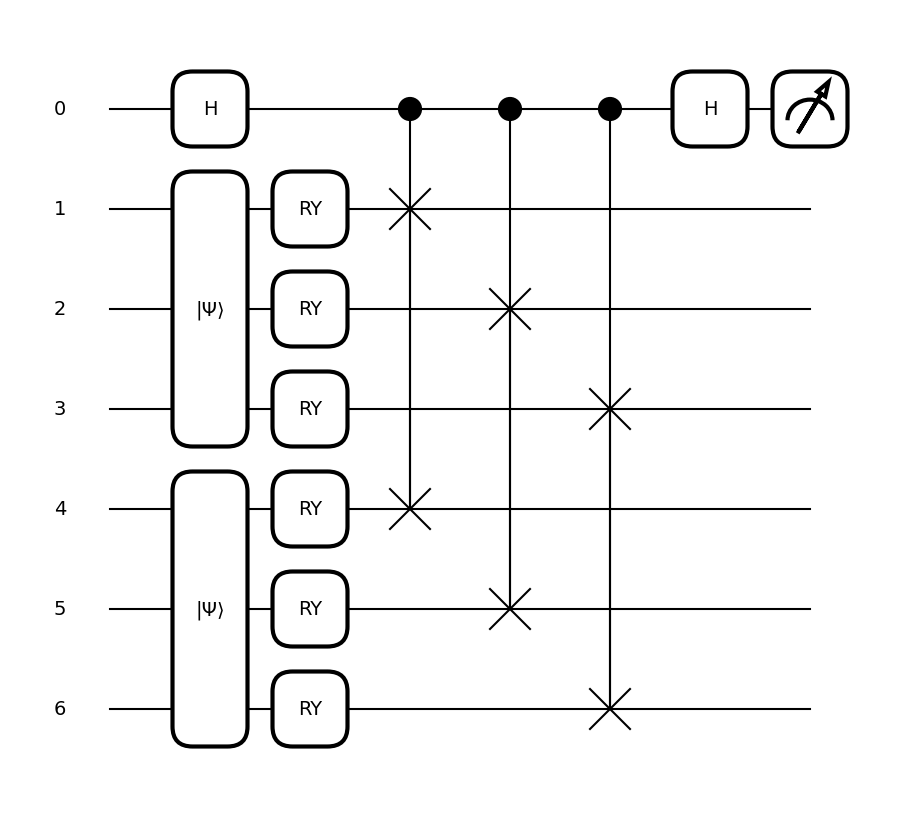

In [ ]:
  qml.draw_mpl(classifier_swap)(["hola", "perro", "amigo"])

In [ ]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.2 MB/s eta 0:00:00


# Prueba

In [ ]:
!pip install fasttext numpy
!wget -q -O cc.en.300.bin.gz "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz"
!gunzip cc.en.300.bin.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313470 sha256=1110e736efc593180a70be60e3de5c40de7bfc74b488b19e1ee343d349bb7d8b
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import fasttext
import numpy as np

model = fasttext.load_model("cc.en.300.bin")

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

vec_apple = model.get_word_vector("apple")
vec_orange = model.get_word_vector("pear")
vec_december = model.get_word_vector("december")
vec_google = model.get_word_vector("google")
vec_dog = model.get_word_vector("dog")
vec_cat = model.get_word_vector("cat")
vec_moon = model.get_word_vector("moon")

sim_apple_orange = cosine_similarity(vec_apple, vec_orange)
sim_december_google = cosine_similarity(vec_december, vec_google)
sim_dog_cat = cosine_similarity(vec_dog, vec_cat)
sim_dog_moon = cosine_similarity(vec_dog, vec_moon)

print("Similitud entre 'apple' y 'pear':", sim_apple_orange)
print("Similitud entre 'december' y 'google':", sim_december_google)
print("Similitud entre 'dog' y 'cat':", sim_dog_cat)
print("Similitud entre 'dog' y 'moon':", sim_dog_moon)


Similitud entre 'apple' y 'pear': 0.66684735
Similitud entre 'december' y 'google': 0.20823516
Similitud entre 'dog' y 'cat': 0.70786107
Similitud entre 'dog' y 'moon': 0.18001257


In [ ]:
!pip install qiskit
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, Aer
from qiskit.compiler import transpile
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt

# Definir el vocabulario con sus ángulos de fase
vocabulary = {
    "hola": 0.0,
    "mundo": np.pi / 4,
    "amigo": np.pi / 2,
    "casa": 3 * np.pi / 4,
    "perro": np.pi,
    "gato": 5 * np.pi / 4,
    "sol": 3 * np.pi / 2,
    "luna": 7 * np.pi / 4
}

# Seleccionar el backend simulador del statevector
simulator = Aer.get_backend('statevector_simulator')

# Diccionario para almacenar los statevectors
states = {}


for word, phase in vocabulary.items():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.rz(phase, 0)
    qc.save_statevector(label=f"sv_{word}")

    transpiled_circ = transpile(qc, simulator)
    result = simulator.run(transpiled_circ).result()

    statevector = result.data(0)[f"sv_{word}"]
    states[word] = statevector

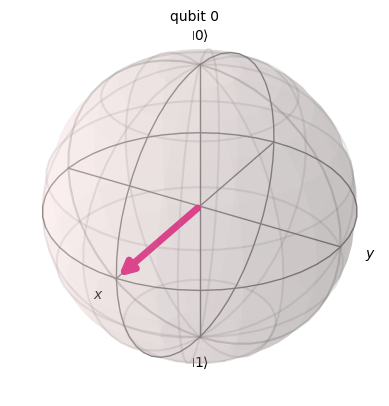

In [ ]:
plot_bloch_multivector(states["hola"])

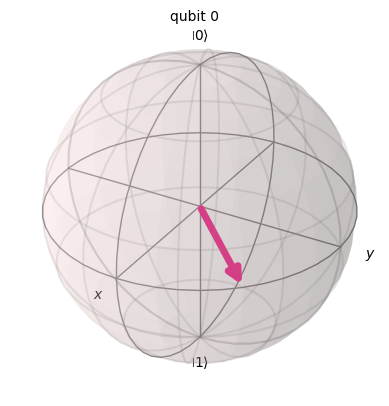

In [ ]:
plot_bloch_multivector(states["mundo"])

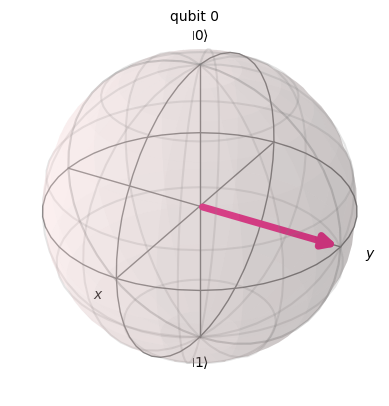

In [ ]:
plot_bloch_multivector(states["amigo"])

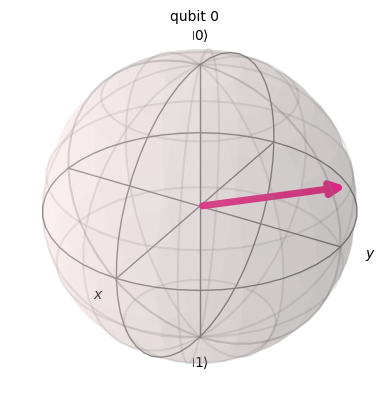

In [ ]:
plot_bloch_multivector(states["casa"])

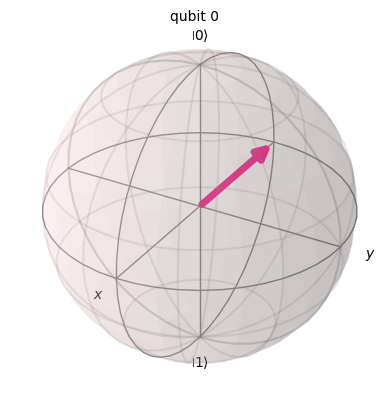

In [ ]:
plot_bloch_multivector(states["perro"])

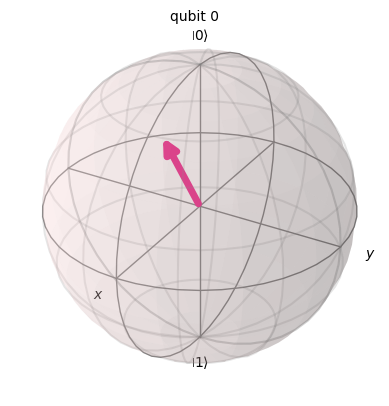

In [ ]:
plot_bloch_multivector(states["gato"])

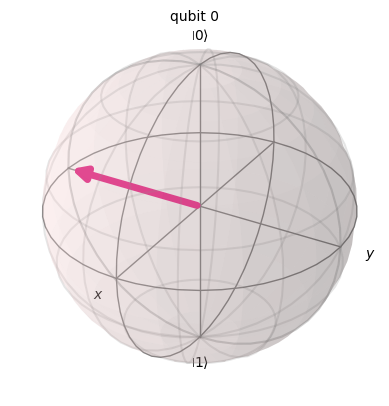

In [ ]:
plot_bloch_multivector(states["sol"])

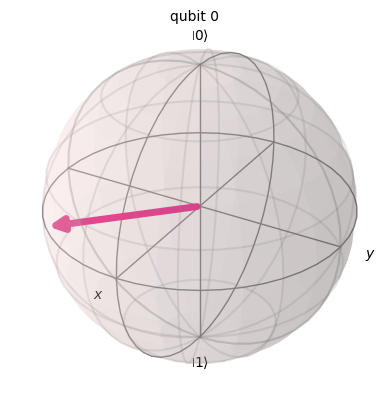

In [ ]:
plot_bloch_multivector(states["luna"])

In [ ]:
import fasttext
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, Aer
from qiskit.compiler import transpile
from qiskit.visualization import plot_bloch_multivector

from sklearn.manifold import MDS

model = fasttext.load_model("cc.en.300.bin")

def get_similarity(word1, word2):
    """Calcula la similitud coseno entre dos palabras usando FastText."""
    vec1 = model.get_word_vector(word1)
    vec2 = model.get_word_vector(word2)
    sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return sim

words = ["hello", "world", "friend", "house", "dog", "cat", "sun", "moon"]
n = len(words)

similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity_matrix[i, j] = get_similarity(words[i], words[j])

distance_matrix = 1.0 - similarity_matrix

mds_2d = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords_2d = mds_2d.fit_transform(distance_matrix)

r_vals = np.sqrt(coords_2d[:,0]**2 + coords_2d[:,1]**2)
r_max = np.max(r_vals)

if r_max == 0:
    r_max = 1e-9

angles_dict = {}

for i, w in enumerate(words):
    x, y = coords_2d[i]
    r = np.sqrt(x*x + y*y)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2*np.pi

    theta = np.pi * (r / r_max)

    angles_dict[w] = (theta, phi)

simulator = Aer.get_backend('statevector_simulator')
states = {}

for w, (theta, phi) in angles_dict.items():

    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    qc.save_statevector(label=f"sv_{w}")

    transpiled_circ = transpile(qc, simulator)
    result = simulator.run(transpiled_circ).result()
    statevector = result.data(0)[f"sv_{w}"]
    states[w] = statevector


print("Palabras y parámetros (theta, phi) en la esfera de Bloch:")
for w in words:
    t, p = angles_dict[w]
    print(f"{w}: theta={t:.3f}, phi={p:.3f}")

Palabras y parámetros (theta, phi) en la esfera de Bloch:
hello: theta=2.899, phi=0.691
world: theta=3.142, phi=4.476
friend: theta=2.627, phi=1.513
house: theta=2.458, phi=3.607
dog: theta=2.410, phi=2.396
cat: theta=2.061, phi=2.641
sun: theta=2.865, phi=5.523
moon: theta=2.265, phi=5.845


In [ ]:
sim_sun_moon = get_similarity("friend", "house")
print("Sim(sun, moon) =", sim_sun_moon)



Sim(sun, moon) = 0.26537934


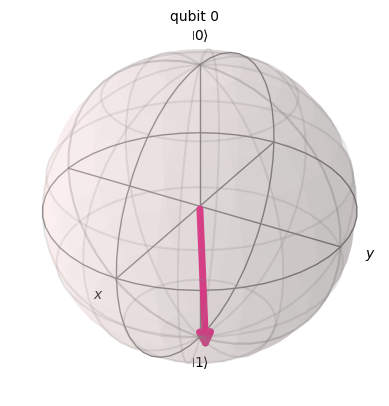

In [ ]:
plot_bloch_multivector(states["hello"])

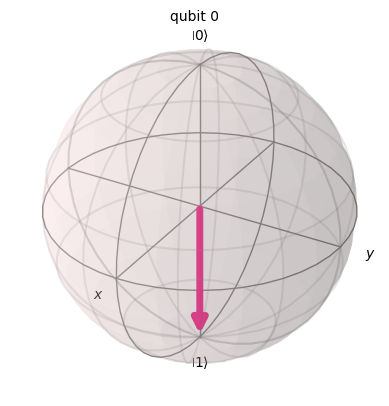

In [ ]:
plot_bloch_multivector(states["world"])

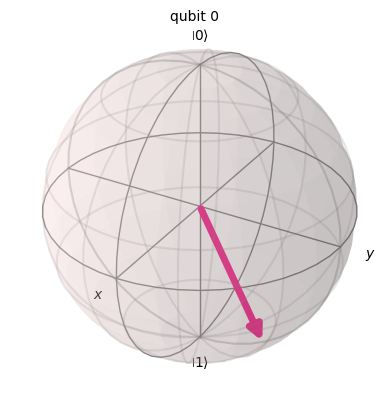

In [ ]:
plot_bloch_multivector(states["friend"])

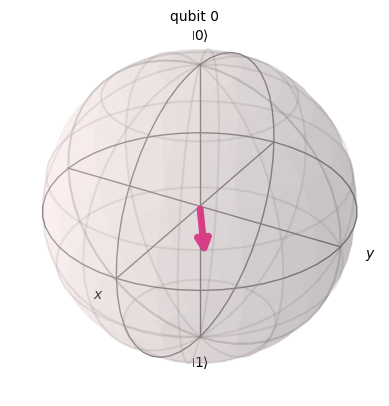

In [ ]:
plot_bloch_multivector(states["house"])

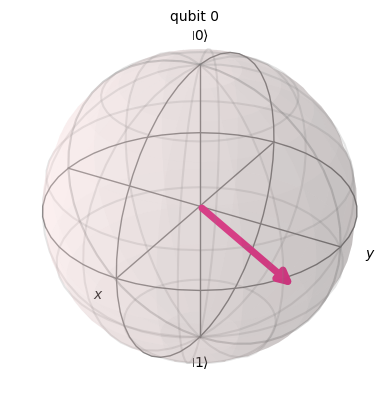

In [ ]:
plot_bloch_multivector(states["dog"])

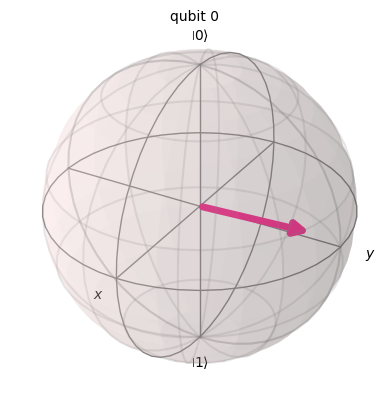

In [ ]:
plot_bloch_multivector(states["cat"])

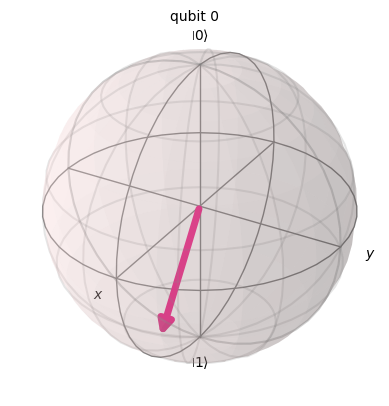

In [ ]:
plot_bloch_multivector(states["sun"])

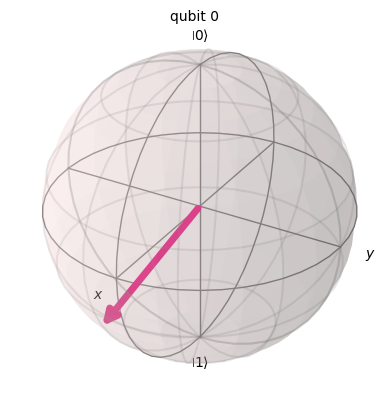

In [ ]:
plot_bloch_multivector(states["moon"])

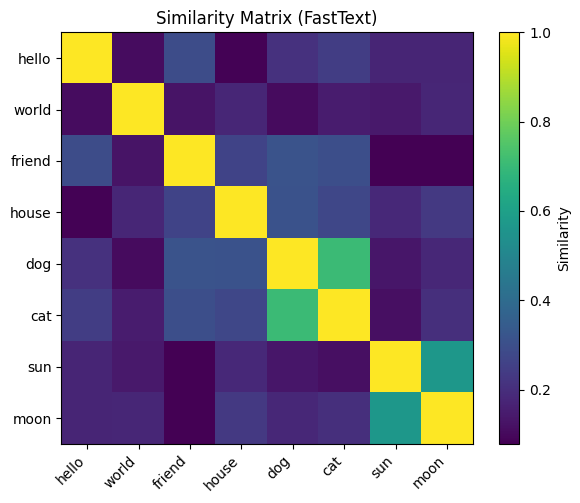

In [ ]:
import fasttext
import numpy as np
import matplotlib.pyplot as plt

model = fasttext.load_model("cc.en.300.bin")

def get_similarity(word1, word2):
    vec1 = model.get_word_vector(word1)
    vec2 = model.get_word_vector(word2)
    sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1)*np.linalg.norm(vec2))
    return sim

words = ["hello", "world", "friend", "house", "dog", "cat", "sun", "moon"]
n = len(words)

similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity_matrix[i, j] = get_similarity(words[i], words[j])

plt.figure(figsize=(6,5))
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Similarity")

# Etiquetas de los ejes
plt.xticks(range(n), words, rotation=45, ha='right')
plt.yticks(range(n), words)

plt.title("Similarity Matrix (FastText)")
plt.tight_layout()
plt.show()


In [ ]:
import fasttext
import numpy as np
from sklearn.decomposition import PCA

model = fasttext.load_model("cc.en.300.bin")

words = ["apple", "orange", "december", "google", "computer", "science", "quantum", "language"]

embeddings = np.array([model.get_word_vector(word) for word in words])

pca = PCA(n_components=1)
reduced = pca.fit_transform(embeddings)

min_val = np.min(reduced)
max_val = np.max(reduced)
normalized = (reduced - min_val) / (max_val - min_val)

angles = 2 * np.pi * normalized

for word, angle in zip(words, angles):
    print(f"Word: {word:10s} -> Angle: {angle[0]:.4f} rad")


Word: apple      -> Angle: 0.0000 rad
Word: orange     -> Angle: 2.5154 rad
Word: december   -> Angle: 5.4801 rad
Word: google     -> Angle: 4.9020 rad
Word: computer   -> Angle: 5.7121 rad
Word: science    -> Angle: 6.2832 rad
Word: quantum    -> Angle: 5.8739 rad
Word: language   -> Angle: 6.1265 rad


In [ ]:
import os
import pandas as pd
import re
import math
import pennylane as qml
from pennylane import numpy as np
import random
import fasttext
from sklearn.decomposition import PCA

csv_path = 'bbc-news-data.csv'
if os.path.exists(csv_path):
    print("El archivo existe. Procediendo a cargarlo...")
    try:
        df = pd.read_csv(csv_path, sep='\t', engine='python')
        print("Archivo cargado exitosamente.")
        print(df.head())
    except pd.errors.ParserError as e:
        print("Error al parsear el archivo CSV:", e)
    except Exception as e:
        print("Ocurrió un error al cargar el archivo:", e)
else:
    print("El archivo no existe en la ruta especificada:", csv_path)

headlines = df["title"].dropna().tolist()
headlines = [hl.lower() for hl in headlines]


all_text = " ".join(headlines)
all_text = re.sub(r"[^\w\s]", "", all_text)
all_words = all_text.split()

# Filtrar para quedarse solo con palabras alfabéticas
filtered_words = [w for w in all_words if w.isalpha()]

vocab = sorted(set(filtered_words))
vocab_size = len(vocab)
print("Tamaño del vocabulario filtrado:", vocab_size)

print("Cargando modelo fastText...")
ft_model = fasttext.load_model("cc.en.300.bin")
print("Modelo fastText cargado.")

# Obtener embeddings para cada palabra del vocabulario
embeddings = []
for word in vocab:
    embeddings.append(ft_model.get_word_vector(word))
embeddings = np.array(embeddings)  # Matriz de (vocab_size x 300)

# Reducir la dimensionalidad a 1 usando PCA
pca = PCA(n_components=1)
reduced = pca.fit_transform(embeddings)

# Normalizar los valores reducidos al rango [0, 1]
min_val = np.min(reduced)
max_val = np.max(reduced)
normalized = (reduced - min_val) / (max_val - min_val)

# Mapear los valores normalizados a ángulos en [0, 2π)
angles = 2 * math.pi * normalized  # (vocab_size, 1)

vocabulary = {word: float(angle) for word, angle in zip(vocab, angles)}

print("Ejemplo de asignación de ángulos:")
for word in vocab[:10]:
    print(f"  {word:15s} -> {vocabulary[word]:.4f} rad")

reference_headline = random.choice(headlines)

reference_seq = re.sub(r"[^\w\s]", "", reference_headline).split()
L = len(reference_seq)
print(f"Titular de referencia seleccionado ({L} palabras):")
print(reference_headline)

num_total = 1 + 2 * L
dev = qml.device("default.qubit", wires=num_total, shots=None)


def encode_word(word, wire):
    qml.Hadamard(wires=wire)
    qml.RZ(vocabulary[word], wires=wire)

def prepare_sequence(sequence, wires):
    for word, wire in zip(sequence, wires):
        encode_word(word, wire)

def random_sequence():
    return [random.choice(vocab) for _ in range(L)]

def neighbor_sequence(seq):
    new_seq = seq.copy()
    idx = random.randrange(len(new_seq))
    alternatives = [w for w in vocab if w != new_seq[idx]]
    new_seq[idx] = random.choice(alternatives)
    return new_seq

def sequence_to_string(seq):
    return " ".join(seq)

theta_A = 0.2
theta_B = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):

    # Registro candidato
    prepare_sequence(candidate_seq, wires=range(1, L+1))
    for i in range(1, L+1):
        qml.RY(theta_A, wires=i)

    # Registro de referencia
    prepare_sequence(reference_seq, wires=range(L+1, 2*L+1))
    for i in range(L+1, 2*L+1):
        qml.RY(theta_B, wires=i)

    # SWAP test:
    qml.Hadamard(wires=0)
    for i in range(L):
        qml.CSWAP(wires=[0, i+1, i+L+1])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):
    probs = classifier_swap(seq)
    fidelity = 2 * probs[0] - 1
    return fidelity**(1/L) if fidelity > 0 else 0

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    current = random_sequence()
    current_score = score_sequence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor_sequence(current)
        candidate_score = score_sequence(candidate)
        delta = candidate_score - current_score
        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, candidate_score
        if current_score > best_score:
            best, best_score = candidate, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria encontrada en la iteración {t}.")
            break

    return best, best_score, t

if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    print("Búsqueda de un titular con score >= 0.95 usando codificación por fase.")
    best_candidate, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)
    print("\nTitular generado:", sequence_to_string(best_candidate))
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")
    print("\nTitular de referencia:", sequence_to_string(reference_seq))


El archivo existe. Procediendo a cargarlo...
Archivo cargado exitosamente.
   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                             content  
0   Quarterly profits at US media giant TimeWarne...  
1   The dollar has hit its highest level against ...  
2   The owners of embattled Russian oil giant Yuk...  
3   British Airways has blamed high fuel prices f...  
4   Shares in UK drinks and food firm Allied Dome...  
Tamaño del vocabulario filtrado: 3753
Cargando modelo fastText...
Modelo fastText cargado.
Ejemplo de asignación de ángulos:
  a               -> 1.3315 rad
  aaas            -> 1.2730 rad
  aaliyah         -> 0.8850 rad
  abandoned       -

<ipython-input-20-d87cb43de619>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vocabulary = {word: float(angle) for word, angle in zip(vocab, angles)}


Solución satisfactoria encontrada en la iteración 76.

Titular generado: riots narrowly wada alert aaliyah electronics questioned
Score obtenido: 0.9549 (en 76 iteraciones)

Titular de referencia: india and iran in gas export deal


In [ ]:
import os
import re
import math
import random

import pandas as pd
import fasttext
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import nltk
nltk.download('all')
from nltk import pos_tag
from nltk.tokenize import word_tokenize

random.seed(42)
np.random.seed(42)

# Ajustes de filtrado de vocabulario
MIN_FREQ = 3     # Frecuencia mínima de una palabra para incluirla
TOPK_NEIGHBORS = 30  # Número de vecinos semánticos a considerar


csv_path = 'bbc-news-data.csv'
if not os.path.exists(csv_path):
    print("El archivo no existe en la ruta especificada:", csv_path)
    exit()

print("El archivo existe. Procediendo a cargarlo...")
try:
    df = pd.read_csv(csv_path, sep='\t', engine='python')
    print("Archivo cargado exitosamente.")
    print(df.head())
except pd.errors.ParserError as e:
    print("Error al parsear el archivo CSV:", e)
    exit()
except Exception as e:
    print("Ocurrió un error al cargar el archivo:", e)
    exit()

headlines = df["title"].dropna().tolist()
headlines = [hl.lower() for hl in headlines]

all_text = " ".join(headlines)
all_text = re.sub(r"[^\w\s]", "", all_text)
all_words = all_text.split()

# Filtrar solo palabras alfabéticas
filtered_words = [w for w in all_words if w.isalpha()]

# Calcular la frecuencia de cada palabra
freq_dict = {}
for w in filtered_words:
    freq_dict[w] = freq_dict.get(w, 0) + 1

# Palabras que aparezcan al menos MIN_FREQ veces
filtered_words = [w for w in filtered_words if freq_dict[w] >= MIN_FREQ]
vocab = sorted(set(filtered_words))
vocab_size = len(vocab)
print(f"Tamaño del vocabulario filtrado (freq >= {MIN_FREQ}): {vocab_size}")

print("Etiquetando palabras con NLTK POS Tag...")

pos_map = {}
BATCH_SIZE = 500
for i in range(0, len(vocab), BATCH_SIZE):
    batch_words = vocab[i:i+BATCH_SIZE]
    tagged = pos_tag(batch_words)
    for word, tag in tagged:
        pos_map[word] = tag

print("Cargando modelo fastText (cc.en.300.bin)...")
ft_model = fasttext.load_model("cc.en.300.bin")
print("Modelo fastText cargado.")

# Obtener embeddings de cada palabra en vocab
embeddings = []
for w in vocab:
    emb = ft_model.get_word_vector(w)
    embeddings.append(emb)
embeddings = np.array(embeddings)

# Reducir a 2D con PCA y mapear a (theta, phi) para cada palabra

pca = PCA(n_components=2)
reduced_2d = pca.fit_transform(embeddings)  # (vocab_size, 2)

# Calcular rangos
min_pc1, max_pc1 = np.min(reduced_2d[:, 0]), np.max(reduced_2d[:, 0])
min_pc2, max_pc2 = np.min(reduced_2d[:, 1]), np.max(reduced_2d[:, 1])

def scale_to_interval(value, old_min, old_max, new_min, new_max):
    if old_max == old_min:  # prevenir div / 0
        return 0.0
    return new_min + (value - old_min)*(new_max - new_min)/(old_max - old_min)

angles_2d = {}
for i, w in enumerate(vocab):
    pc1, pc2 = reduced_2d[i]
    theta = scale_to_interval(pc1, min_pc1, max_pc1, 0, math.pi)
    phi   = scale_to_interval(pc2, min_pc2, max_pc2, 0, 2*math.pi)
    angles_2d[w] = (theta, phi)

print(f"Calculando top-{TOPK_NEIGHBORS} vecinos por palabra (misma POS)...")
similar_words = {}

sim_matrix = cosine_similarity(embeddings, embeddings)

for i, w in enumerate(vocab):
    tag_w = pos_map[w]
    sims = sim_matrix[i]
    idx_sorted = np.argsort(sims)[::-1]
    neighbors = []
    for idx in idx_sorted:
        if idx == i:
            continue
        w2 = vocab[idx]
        # sólo palabras con el MISMO POS
        if pos_map[w2][:2] == tag_w[:2]:
            neighbors.append(w2)
        if len(neighbors) >= TOPK_NEIGHBORS:
            break
    similar_words[w] = neighbors


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root

El archivo existe. Procediendo a cargarlo...
Archivo cargado exitosamente.
   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                             content  
0   Quarterly profits at US media giant TimeWarne...  
1   The dollar has hit its highest level against ...  
2   The owners of embattled Russian oil giant Yuk...  
3   British Airways has blamed high fuel prices f...  
4   Shares in UK drinks and food firm Allied Dome...  
Tamaño del vocabulario filtrado (freq >= 3): 1000
Etiquetando palabras con NLTK POS Tag...
Cargando modelo fastText (cc.en.300.bin)...
Modelo fastText cargado.
Calculando top-30 vecinos por palabra (misma POS)...
Titular de referencia selec

In [ ]:
reference_headline = random.choice(headlines)
reference_seq = re.sub(r"[^\w\s]", "", reference_headline).split()

reference_seq = [w for w in reference_seq if w in vocab]

L = len(reference_seq)
if L == 0:
    print("El titular de referencia quedó vacío tras el filtrado. Se usará uno artificial.")
    reference_seq = ["dollar", "gains"]  # Ejemplo
    L = 2
print(f"Titular de referencia seleccionado ({L} palabras):")
print(reference_headline)

num_total = 1 + 2*L
dev = qml.device("default.qubit", wires=num_total, shots=None)

def encode_word(word, wire):
    theta, phi = angles_2d[word]
    qml.RY(theta, wires=wire)
    qml.RZ(phi, wires=wire)

def prepare_sequence(sequence, wires):
    for word, w in zip(sequence, wires):
        encode_word(word, w)

def random_sequence():
    return [random.choice(vocab) for _ in range(L)]

def neighbor_sequence(seq):

    if L == 0:
        return seq
    new_seq = seq.copy()
    idx = random.randrange(L)
    w_original = new_seq[idx]
    neighs = similar_words[w_original]
    if len(neighs) > 0:
        new_seq[idx] = random.choice(neighs)
    return new_seq

def sequence_to_string(seq):
    return " ".join(seq)

theta_A = 0.2
theta_B = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):
    # Candidato
    prepare_sequence(candidate_seq, wires=range(1, L+1))
    for i in range(1, L+1):
        qml.RY(theta_A, wires=i)

    # Referencia
    prepare_sequence(reference_seq, wires=range(L+1, 2*L+1))
    for i in range(L+1, 2*L+1):
        qml.RY(theta_B, wires=i)

    # SWAP test
    qml.Hadamard(wires=0)
    for i in range(L):
        qml.CSWAP(wires=[0, i+1, i+L+1])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):
    if L == 0:
        return 0.0
    probs = classifier_swap(seq)
    fidelity = 2*probs[0] - 1
    return fidelity**(1/L) if fidelity > 0 else 0

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    if L == 0:
        return [], 0, 0

    current = random_sequence()
    current_score = score_sequence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor_sequence(current)
        candidate_score = score_sequence(candidate)
        delta = candidate_score - current_score

        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, candidate_score

        if current_score > best_score:
            best, best_score = current, current_score

        if best_score >= threshold:
            print(f"Solución satisfactoria encontrada en la iteración {t}.")
            break

    return best, best_score, t

if __name__ == "__main__":
    print("\nBúsqueda de un titular con score >= 0.95 usando:")
    print("- Codificación de 2D (PC1, PC2) en un qubit por palabra")
    print("- Filtrado de vocabulario por frecuencia")
    print("- Vecinos semánticos con el mismo POS\n")

    best_candidate, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)

    print("\nTitular generado:", sequence_to_string(best_candidate))
    print(f"Score obtenido: {best_score:.4f} (en {iters} iteraciones)")
    print("\nTitular de referencia:", sequence_to_string(reference_seq))

Titular de referencia seleccionado (3 palabras):
johnson accuses british sprinters

Búsqueda de un titular con score >= 0.95 usando:
- Codificación de 2D (PC1, PC2) en un qubit por palabra
- Filtrado de vocabulario por frecuencia
- Vecinos semánticos con el mismo POS

Solución satisfactoria encontrada en la iteración 3.

Titular generado: injury review walmart
Score obtenido: 0.9921 (en 3 iteraciones)

Titular de referencia: johnson british sprinters


In [ ]:
import os
import re
import math
import random

import pandas as pd
import fasttext
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA

N_COMPONENTS = 4  # 4 dimensiones de PCA
random.seed(42)
np.random.seed(42)

csv_path = 'bbc-news-data.csv'
if not os.path.exists(csv_path):
    print("Archivo no encontrado:", csv_path)
    exit()

df = pd.read_csv(csv_path, sep='\t', engine='python')
headlines = df["title"].dropna().tolist()
headlines = [hl.lower() for hl in headlines]

all_text = " ".join(headlines)
all_text = re.sub(r"[^\w\s]", "", all_text)
all_words = all_text.split()
vocab = sorted(set(all_words))
print(f"Vocab size: {len(vocab)}")

print("Cargando modelo fastText...")
ft_model = fasttext.load_model("cc.en.300.bin")
print("Modelo fastText cargado.")

embeddings = []
for w in vocab:
    emb = ft_model.get_word_vector(w)
    embeddings.append(emb)
embeddings = np.array(embeddings)  # (vocab_size x 300)

pca = PCA(n_components=N_COMPONENTS)
reduced_4d = pca.fit_transform(embeddings)

# Rango mínimo/máximo para cada componente
mins = np.min(reduced_4d, axis=0)
maxs = np.max(reduced_4d, axis=0)

def scale_to_interval(value, old_min, old_max, new_min, new_max):
    if old_max == old_min:
        return 0.0
    return new_min + (value - old_min)*(new_max - new_min)/(old_max - old_min)

pca_map = {}
for i, w in enumerate(vocab):
    pc1, pc2, pc3, pc4 = reduced_4d[i]
    theta1 = scale_to_interval(pc1, mins[0], maxs[0], 0, math.pi)
    phi1   = scale_to_interval(pc2, mins[1], maxs[1], 0, 2*math.pi)
    theta2 = scale_to_interval(pc3, mins[2], maxs[2], 0, math.pi)
    phi2   = scale_to_interval(pc4, mins[3], maxs[3], 0, 2*math.pi)
    pca_map[w] = (theta1, phi1, theta2, phi2)

reference_headline = random.choice(headlines)
reference_seq = re.sub(r"[^\w\s]", "", reference_headline).split()
L = len(reference_seq)
print(f"Titular referencia ({L} palabras): {reference_headline}")

# Si la secuencia queda vacía, forzamos algo
if L == 0:
    reference_seq = ["dollar","boost"]
    L = 2
    print("Secuencia de referencia vacía. Usamos:", reference_seq)

num_wires = 1 + 4*L
dev = qml.device("default.qubit", wires=num_wires, shots=None)

# Codificar 4D en 2 qubits

def encode_word_4D(word, wire1, wire2):

    theta1, phi1, theta2, phi2 = pca_map[word]
    # Primer qubit
    qml.RY(theta1, wires=wire1)
    qml.RZ(phi1, wires=wire1)

    # Segundo qubit
    qml.RY(theta2, wires=wire2)
    qml.RZ(phi2, wires=wire2)

def prepare_sequence_4D(sequence, start_wire):
    for i, word in enumerate(sequence):
        w1 = start_wire + 2*i
        w2 = start_wire + 2*i + 1
        encode_word_4D(word, w1, w2)

thetaA = 0.2
thetaB = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):
    # Preparar candidato
    prepare_sequence_4D(candidate_seq, start_wire=1)
    # Pequeña rotación adicional
    for i in range(L):
        w1 = 1 + 2*i
        w2 = 1 + 2*i + 1
        qml.RY(thetaA, wires=w1)
        qml.RY(thetaA, wires=w2)

    # Preparar referencia
    start_ref = 1 + 2*L  # = 2L+1
    prepare_sequence_4D(reference_seq, start_wire=start_ref)
    for i in range(L):
        w1 = start_ref + 2*i
        w2 = start_ref + 2*i + 1
        qml.RY(thetaB, wires=w1)
        qml.RY(thetaB, wires=w2)

    # SWAP test
    qml.Hadamard(wires=0)
    for i in range(L):
        cand1 = 1 + 2*i
        cand2 = 1 + 2*i + 1
        ref1  = start_ref + 2*i
        ref2  = start_ref + 2*i + 1
        qml.CSWAP(wires=[0, cand1, ref1])
        qml.CSWAP(wires=[0, cand2, ref2])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):

    if L == 0:
        return 0.0
    probs = classifier_swap(seq)
    fid = 2*probs[0] - 1
    return fid**(1/L) if fid > 0 else 0

if __name__ == "__main__":
    print(f"Total qubits: {num_wires}")
    print("Titular de referencia:", reference_seq)

    same_score = score_sequence(reference_seq)
    print(f"\nScore con la MISMA secuencia: {same_score:.4f}")

    random_seq = [random.choice(vocab) for _ in range(L)]
    rnd_score = score_sequence(random_seq)
    print(f"Random seq: {random_seq}")
    print(f"Score random seq: {rnd_score:.4f}")


Vocab size: 3866
Cargando modelo fastText...
Modelo fastText cargado.
Titular referencia (5 palabras): germany calls for eu reform
Total qubits: 21
Titular de referencia: ['germany', 'calls', 'for', 'eu', 'reform']

Score con la MISMA secuencia: 0.9961
Random seq: ['90', 'seamen', 'dual', 'deserve', 'dame']
Score random seq: 0.1181


In [ ]:
import os
import re
import math
import random

import pandas as pd
import fasttext
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk import pos_tag


# PARÁMETROS Y CONSTANTES
MIN_FREQ = 3           # Frecuencia mínima de aparición de una palabra
TOPK_NEIGHBORS = 30    # Número de vecinos semánticos
N_COMPONENTS = 4       # Dimensiones PCA (4 => 2 qubits/word)
random.seed(42)
np.random.seed(42)

csv_path = 'bbc-news-data.csv'
if not os.path.exists(csv_path):
    print("Archivo no encontrado:", csv_path)
    raise SystemExit

print("Cargando CSV...")
df = pd.read_csv(csv_path, sep='\t', engine='python')
df.dropna(subset=["title"], inplace=True)
headlines = [t.lower() for t in df["title"]]

all_text = " ".join(headlines)
all_text = re.sub(r"[^\w\s]", "", all_text)
all_words = all_text.split()

# Frecuencia
freq_dict = {}
for w in all_words:
    freq_dict[w] = freq_dict.get(w, 0) + 1

filtered_words = [w for w in all_words if w.isalpha() and freq_dict[w] >= MIN_FREQ]
vocab = sorted(set(filtered_words))
vocab_size = len(vocab)
print(f"Tamaño del vocab filtrado (freq>={MIN_FREQ}): {vocab_size}")

print("Etiquetando palabras (POS Tag)...")
BATCH_SIZE = 500
pos_map = {}
for i in range(0, vocab_size, BATCH_SIZE):
    batch_words = vocab[i:i+BATCH_SIZE]
    tagged = pos_tag(batch_words)
    for w, tag in tagged:
        pos_map[w] = tag

print("Cargando modelo fastText (cc.en.300.bin)...")
ft_model = fasttext.load_model("cc.en.300.bin")
print("Modelo fastText cargado.")

embeddings = []
for w in vocab:
    emb = ft_model.get_word_vector(w)
    embeddings.append(emb)
embeddings = np.array(embeddings)

pca = PCA(n_components=N_COMPONENTS)
reduced_4d = pca.fit_transform(embeddings)

mins = np.min(reduced_4d, axis=0)
maxs = np.max(reduced_4d, axis=0)

def scale_to_interval(value, old_min, old_max, new_min, new_max):
    if old_max == old_min:
        return 0.0
    return new_min + (value - old_min)*(new_max - new_min)/(old_max - old_min)

pca_map = {}
for i, w in enumerate(vocab):
    pc1, pc2, pc3, pc4 = reduced_4d[i]
    theta1 = scale_to_interval(pc1, mins[0], maxs[0], 0, math.pi)
    phi1   = scale_to_interval(pc2, mins[1], maxs[1], 0, 2*math.pi)
    theta2 = scale_to_interval(pc3, mins[2], maxs[2], 0, math.pi)
    phi2   = scale_to_interval(pc4, mins[3], maxs[3], 0, 2*math.pi)
    pca_map[w] = (theta1, phi1, theta2, phi2)

print(f"Calculando top-{TOPK_NEIGHBORS} vecinos semánticos (mismo POS)...")
sim_matrix = cosine_similarity(embeddings, embeddings)
vocab_index = {w: i for i, w in enumerate(vocab)}

similar_words = {}
for i, w in enumerate(vocab):
    tag_w = pos_map[w]
    sims = sim_matrix[i]
    idx_sorted = sims.argsort()[::-1]
    neighbors = []
    for idx in idx_sorted:
        if idx == i:
            continue
        w2 = vocab[idx]
        if pos_map[w2][:2] == tag_w[:2]:
            neighbors.append(w2)
        if len(neighbors) >= TOPK_NEIGHBORS:
            break
    similar_words[w] = neighbors

reference_headline = random.choice(headlines)
reference_seq = re.sub(r"[^\w\s]", "", reference_headline).split()
reference_seq = [w for w in reference_seq if w in vocab]
L = len(reference_seq)
if L == 0:
    reference_seq = ["dollar", "boost"]
    L = len(reference_seq)

print(f"\nTitular de referencia ({L} palabras): {reference_headline}")
print("Secuencia tras filtrar:", reference_seq)

num_wires = 1 + 4*L
dev = qml.device("default.qubit", wires=num_wires, shots=None)


def encode_word_4D(word, wire1, wire2):
    theta1, phi1, theta2, phi2 = pca_map[word]
    # Qubit 1
    qml.RY(theta1, wires=wire1)
    qml.RZ(phi1, wires=wire1)
    # Qubit 2
    qml.RY(theta2, wires=wire2)
    qml.RZ(phi2, wires=wire2)

def prepare_sequence_4D(sequence, start_wire):

    for i, w in enumerate(sequence):
        w1 = start_wire + 2*i
        w2 = start_wire + 2*i + 1
        encode_word_4D(w, w1, w2)

thetaA = 0.2
thetaB = 0.1

@qml.qnode(dev)
def classifier_swap(candidate_seq):

    prepare_sequence_4D(candidate_seq, start_wire=1)
    for i in range(L):
        w1 = 1 + 2*i
        w2 = 1 + 2*i + 1
        qml.RY(thetaA, wires=w1)
        qml.RY(thetaA, wires=w2)

    start_ref = 1 + 2*L
    prepare_sequence_4D(reference_seq, start_wire=start_ref)
    for i in range(L):
        w1 = start_ref + 2*i
        w2 = start_ref + 2*i + 1
        qml.RY(thetaB, wires=w1)
        qml.RY(thetaB, wires=w2)

    qml.Hadamard(wires=0)
    for i in range(L):
        cand1 = 1 + 2*i
        cand2 = 1 + 2*i + 1
        ref1  = start_ref + 2*i
        ref2  = start_ref + 2*i + 1
        qml.CSWAP(wires=[0, cand1, ref1])
        qml.CSWAP(wires=[0, cand2, ref2])
    qml.Hadamard(wires=0)

    return qml.probs(wires=0)

def score_sequence(seq):

    if L == 0:
        return 0.0
    probs = classifier_swap(seq)
    fid = 2*probs[0] - 1
    return fid**(1/L) if fid > 0 else 0

def random_sequence():
    return [random.choice(vocab) for _ in range(L)]

def neighbor_sequence(seq):
    if L == 0:
        return seq
    new_seq = seq.copy()
    idx = random.randrange(L)
    w_original = new_seq[idx]
    neighs = similar_words[w_original]
    if len(neighs) > 0:
        new_seq[idx] = random.choice(neighs)
    return new_seq

def sequence_to_string(seq):
    return " ".join(seq)

def simulated_annealing(max_iters=500, T0=1.0, threshold=0.95):
    if L == 0:
        return [], 0.0, 0

    current = random_sequence()
    current_score = score_sequence(current)
    best = current
    best_score = current_score

    for t in range(1, max_iters+1):
        T = T0 / t
        candidate = neighbor_sequence(current)
        cand_score = score_sequence(candidate)
        delta = cand_score - current_score
        if delta > 0 or np.exp(delta / T) > random.random():
            current, current_score = candidate, cand_score
        if current_score > best_score:
            best, best_score = current, current_score
        if best_score >= threshold:
            print(f"Solución satisfactoria en iter {t}")
            break

    return best, best_score, t

if __name__ == "__main__":
    print(f"\nVocab size final: {vocab_size}")
    print(f"Titular referencia (L={L}):", reference_seq)
    print(f"Total qubits: {1 + 4*L}")

    print("\nIniciando Simulated Annealing para buscar secuencia con score >= 0.95 ...")
    best_seq, best_score, iters = simulated_annealing(max_iters=1000, T0=1.0, threshold=0.95)

    print("\n=== RESULTADOS ===")
    print("Titular generado:", sequence_to_string(best_seq))
    print(f"Score obtenido: {best_score:.4f}, en {iters} iteraciones")
    print("Titular de referencia:", sequence_to_string(reference_seq))


Cargando CSV...
Tamaño del vocab filtrado (freq>=3): 1000
Etiquetando palabras (POS Tag)...
Cargando modelo fastText (cc.en.300.bin)...
Modelo fastText cargado.
Calculando top-30 vecinos semánticos (mismo POS)...

Titular de referencia (4 palabras): germany calls for eu reform
Secuencia tras filtrar: ['calls', 'for', 'eu', 'reform']

Vocab size final: 1000
Titular referencia (L=4): ['calls', 'for', 'eu', 'reform']
Total qubits: 17

Iniciando Simulated Annealing para buscar secuencia con score >= 0.95 ...

=== RESULTADOS ===
Titular generado: business make pm rejects
Score obtenido: 0.7798, en 1000 iteraciones
Titular de referencia: calls for eu reform
